# 📊 Model Accuracy Timeline

Visualizes the accuracy of open- and closed-source language models over time.

This tool is designed to compare model performance on documentation-based extractive QA tasks.

### 🔧 Tools Used:
- [Yourbench](https://github.com/huggingface/yourbench) – to create the evaluation dataset. I created a MCQ one.
- [Lighteval](https://github.com/huggingface/lighteval) – to generate the detailed results dataset. Used [custom_yourbench_task_mcq.py](https://github.com/huggingface/lighteval/blob/main/examples/custom_tasks_templates/custom_yourbench_task_mcq.py) for a MCQ dataset.

⚠️ Replace private dataset paths with your own or public versions if sharing.

In [ ]:
# Imports and setup
import pandas as pd
import json
from datasets import load_dataset
from huggingface_hub import HfApi
import plotly.graph_objects as go
import plotly.io as pio

api = HfApi()

In [2]:
# Model configuration
model_ids = [
    "Qwen/Qwen3-32B",
    "deepseek-ai/DeepSeek-R1",
    "google/gemma-2-2b-it",
    "google/gemma-3-27b-it",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "meta-llama/Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct",
    "meta-llama/Llama-4-Scout-17B-16E-Instruct"
]

In [3]:
# Update with your public dataset paths
MODEL_DATASETS = {
    "Qwen3-32B": "your_namespace/details_Qwen3-32B",
    "DeepSeek-R1": "your_namespace/details_DeepSeek-R1",
    "gemma-2-2b-it": "your_namespace/details_gemma-2-2b-it",
    "gemma-3-27b-it": "your_namespace/details_gemma-3-27b-it",
    "Mistral-7B-Instruct-v0.3": "your_namespace/details_Mistral-7B-Instruct-v0.3",
    "Llama-3.1-8B-Instruct": "your_namespace/details_Llama-3.1-8B-Instruct",
    "Llama-3.3-70B-Instruct": "your_namespace/details_Llama-3.3-70B-Instruct",
    "Llama-4-Scout-17B-16E-Instruct": "your_namespace/details_Llama-4-Scout-17B-16E-Instruct",
}

In [4]:
# Short names for display
HF_TO_SHORT = {hf_id.split("/")[-1]: name for hf_id, name in zip(model_ids, MODEL_DATASETS)}

In [5]:
# Get upload dates from Hugging Face Hub
upload_dates = {}
for model_id in model_ids:
    info = api.model_info(model_id)
    short_name = model_id.split("/")[-1]
    upload_dates[HF_TO_SHORT[short_name]] = info.created_at.strftime("%Y-%m-%d")

In [6]:
# Extract accuracy metric from dataset
def extract_accuracy(dataset_name: str) -> float:
    try:
        ds = load_dataset(dataset_name, name="results", split="latest", streaming=True)
        df = pd.DataFrame(ds)
        results = json.loads(df["results"][0])
        return round(results["all"]["extractive_match"], 3)
    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")
        return None

In [11]:
# Assemble data into a table
rows = []

for name, dataset in MODEL_DATASETS.items():
    acc = extract_accuracy(dataset)
    rows.append({
        "model": name,
        "accuracy": acc,
        "date": upload_dates.get(name, "N/A"),
        "source": "open-source"
    })

# Add closed-source models manually
rows += [
    {
        "model": "GPT-4.1",
        "accuracy": extract_accuracy("your_namespace/details_gpt-4.1"),
        "date": "2025-04-14",
        "source": "closed-source"
    },
    {
        "model": "claude-3.5-haiku",
        "accuracy": extract_accuracy("your_namespace/details_claude-3.5-haiku"),
        "date": "2024-10-22",
        "source": "closed-source"
    }
]

In [14]:
results_df = pd.DataFrame(rows)
results_df = results_df.sort_values(by="accuracy", ascending=False).reset_index(drop=True)
results_df

,model,accuracy,date,source
0,DeepSeek-R1,0.892,2025-01-20,open-source
1,Qwen3-32B,0.877,2025-04-27,open-source
2,GPT-4.1,0.877,2025-04-14,closed-source
3,gemma-3-27b-it,0.846,2025-03-01,open-source
4,Llama-3.3-70B-Instruct,0.800,2024-11-26,open-source
5,claude-3.5-haiku,0.800,2024-10-22,closed-source
6,Llama-4-Scout-17B-16E-Instruct,0.738,2025-04-02,open-source
7,Mistral-7B-Instruct-v0.3,0.615,2024-05-22,open-source
8,Llama-3.1-8B-Instruct,0.615,2024-07-18,open-source
9,gemma-2-2b-it,0.585,2024-07-16,open-source


In [15]:
# Prepare data for visualization
results_df["date"] = pd.to_datetime(results_df["date"])
results_sorted = results_df.sort_values(by="date")

position_map = {
    "Mistral-7B-Instruct-v0.3": "middle left",
    "Llama-3.3-70B-Instruct": "bottom center",
    "GPT-4.1": "bottom left",
}
text_positions = [position_map.get(m, "top right") for m in results_sorted["model"]]

open_df = results_sorted[results_sorted["source"] == "open-source"]
closed_df = results_sorted[results_sorted["source"] == "closed-source"]

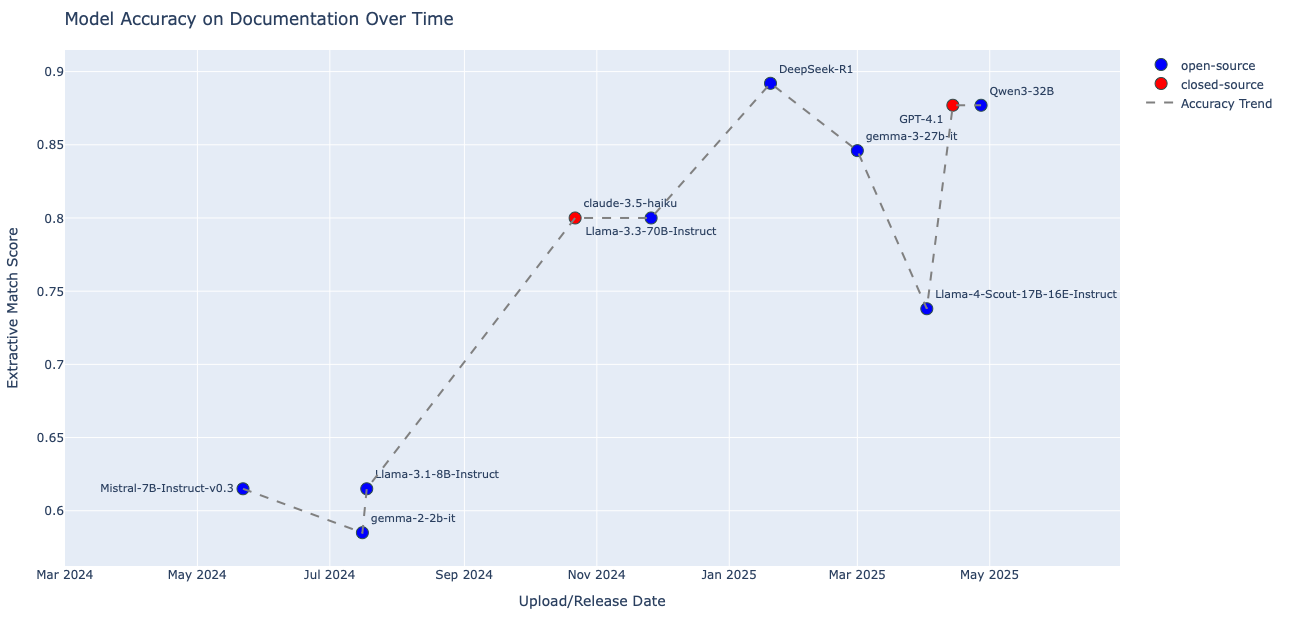

In [16]:
# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=open_df["date"],
    y=open_df["accuracy"],
    mode="markers+text",
    name="open-source",
    marker=dict(color="blue", size=12, line=dict(width=1, color="DarkSlateGrey")),
    text=open_df["model"],
    textposition=[position_map.get(m, "top right") for m in open_df["model"]],
    textfont=dict(size=11),
    hovertext=open_df["model"],
    hoverinfo="text"
))

fig.add_trace(go.Scatter(
    x=closed_df["date"],
    y=closed_df["accuracy"],
    mode="markers+text",
    name="closed-source",
    marker=dict(color="red", size=12, line=dict(width=1, color="DarkSlateGrey")),
    text=closed_df["model"],
    textposition=[position_map.get(m, "top right") for m in closed_df["model"]],
    textfont=dict(size=11),
    hovertext=closed_df["model"],
    hoverinfo="text"
))

fig.add_trace(go.Scatter(
    x=results_sorted["date"],
    y=results_sorted["accuracy"],
    mode="lines",
    line=dict(color="gray", width=2, dash="dash"),
    name="Accuracy Trend"
))

fig.update_layout(
    title="Model Accuracy on Documentation Over Time",
    height=600,
    xaxis_title="Upload/Release Date",
    yaxis_title="Extractive Match Score",
    xaxis=dict(range=["2024-03-01", "2025-06-30"]),
    margin=dict(l=40, r=40, t=50, b=40)
)

fig.show()

In [ ]:
pio.write_image(fig, "model_accuracy_plot.png", width=1600, height=600, scale=2)